In [1]:
import pandas as pd
from ggplot import *

project_id = "the-d-team-164512"

In [8]:
query = """\
SELECT
  d.BrandName AS brand_name
  , DATE(STRFTIME_UTC_USEC(DATE(t.Dispense_Week), "%Y-%m-01")) AS year_month
  , COUNT(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
WHERE d.brandName = 'LIPITOR'
GROUP BY
  brand_name
  , year_month
ORDER BY
  brand_name
  , year_month ASC"""

df_lipitor = pd.read_gbq(query, project_id)
df_lipitor.head(3)

Waiting for job to complete...


,brand_name,year_month,transaction_count
0,LIPITOR,2010-12-01,102
1,LIPITOR,2011-01-01,53268
2,LIPITOR,2011-02-01,47289


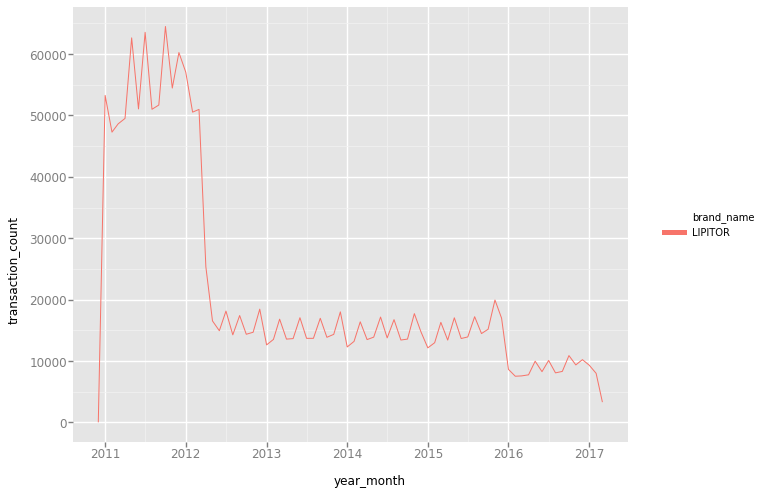

<ggplot: (-9223372036574669778)>

In [9]:
df_lipitor.year_month = pd.Series(df_lipitor.year_month).apply(pd.to_datetime, format='%Y-%m')
ggplot(
    aes(x='year_month', y='transaction_count', colour='brand_name'),
    data=df_lipitor) +\
    geom_line()

In [12]:
query = """\
SELECT
  d.ATCLevel5Code
  , d.BrandName AS brand_name
  , (CASE WHEN d.BrandName = 'LIPITOR' THEN 'LIPITOR' ELSE 'NON LIPITOR' END) AS lipitor
  , DATE(STRFTIME_UTC_USEC(DATE(t.Dispense_Week), "%Y-%m-01")) AS year_month
  , COUNT(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
WHERE d.ATCLevel5Code = 'C10AA05'
GROUP BY
  d.ATCLevel5Code
  , brand_name
  , lipitor
  , year_month
ORDER BY
  d.ATCLevel5Code
  , brand_name
  , year_month ASC
"""
df_rpl = pd.read_gbq(query, project_id)
df_rpl.head(3)

Waiting for job to complete...


,d_ATCLevel5Code,brand_name,lipitor,year_month,transaction_count
0,C10AA05,ATORVACHOL,NON LIPITOR,2012-05-01,24
1,C10AA05,ATORVACHOL,NON LIPITOR,2012-06-01,561
2,C10AA05,ATORVACHOL,NON LIPITOR,2012-07-01,1064


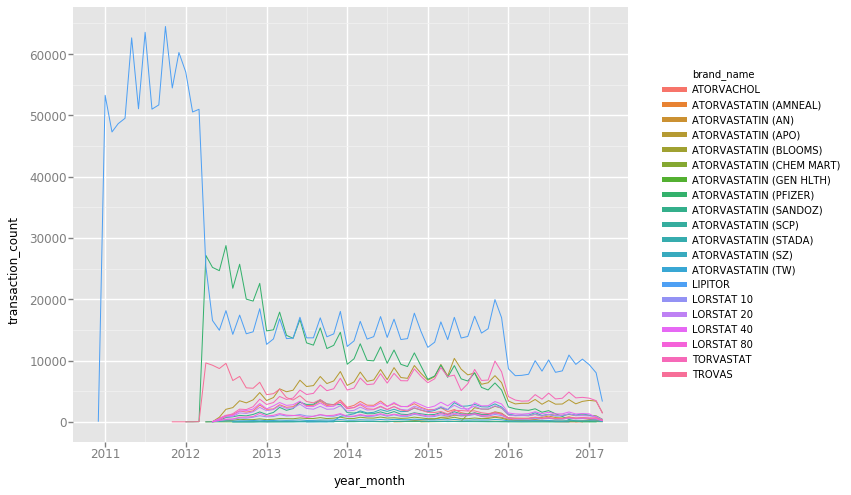

<ggplot: (281796861)>

In [13]:
df_rpl.year_month = pd.Series(df_rpl.year_month).apply(pd.to_datetime, format='%Y-%m')
ggplot(
    aes(x='year_month', y='transaction_count', colour='brand_name'),
    data=df_rpl) +\
    geom_line()

## Lipitor out of patent Nov 2011
As Lipitor goes [out of patent](https://en.wikipedia.org/wiki/Atorvastatin) it is replaced by other statins predominangly versions of atorvastatin.

* who is the first to pick this up? by store? by geography?
* what is the cost impact?
* surprisingly there is no increase in useage?

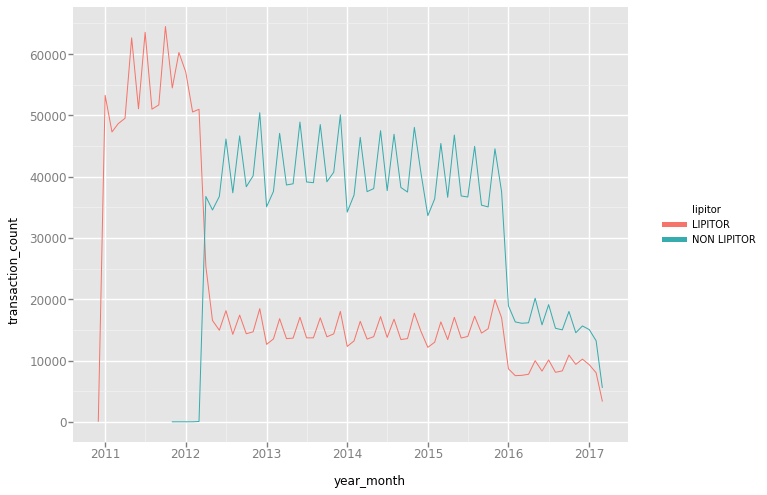

<ggplot: (-9223372036571927573)>

In [40]:
df_lip = df_rpl.groupby(['year_month', 'lipitor']).sum()    
df_lip.reset_index(inplace=True)
df_lip
ggplot(
    aes(x='year_month', y='transaction_count', colour='lipitor'),
    data=df_lip) +\
    geom_line()

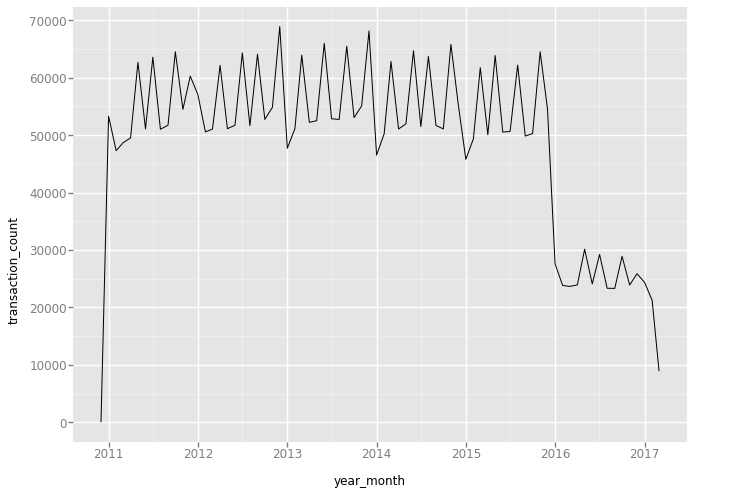

<ggplot: (283443264)>

In [53]:
df_lip_all = df_rpl.groupby(['year_month']).sum()    
df_lip_all.reset_index(inplace=True)
ggplot(
    aes(x='year_month', y='transaction_count'),
    data=df_lip_all) +\
    geom_line(position = 'stack')